In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.cluster import KMeans
import numpy as np
from tabulate import tabulate
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [3]:
data=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data Mining/Mini Project/supermarket_sales.csv")
df = data.copy()
df.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Invoice ID               1000 non-null   object 
 1   Branch                   1000 non-null   object 
 2   City                     1000 non-null   object 
 3   Customer type            1000 non-null   object 
 4   Gender                   1000 non-null   object 
 5   Product line             1000 non-null   object 
 6   Unit price               1000 non-null   float64
 7   Quantity                 1000 non-null   int64  
 8   Tax 5%                   1000 non-null   float64
 9   Total                    1000 non-null   float64
 10  Date                     1000 non-null   object 
 11  Time                     1000 non-null   object 
 12  Payment                  1000 non-null   object 
 13  cogs                     1000 non-null   float64
 14  gross margin percentage  

In [5]:
unique_invoice_ids = df['Invoice ID'].nunique()

print(f"Number of unique Invoice IDs: {unique_invoice_ids}")

Number of unique Invoice IDs: 1000


In [6]:
df.set_index(['Invoice ID'], inplace=True)

In [7]:
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
# Convert 'Time' column to datetime without the default date
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M').dt.time

In [8]:
start_date = df['Date'].min()
end_date = df['Date'].max()
expected_date_range = pd.date_range(start=start_date, end=end_date)

# Find the missing date entries
missing_dates = expected_date_range[~expected_date_range.isin(df['Date'])]
# Print or work with the list of missing dates
print("Missing Dates:")
missing_df_only_dates = pd.DataFrame(missing_dates)
missing_df_only_dates

Missing Dates:


,0


In [9]:
# Combine 'Date' and 'Time' columns
df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))

### Finding the correlation matrix

<ipython-input-10-c800878687de>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot = True)


<Axes: >

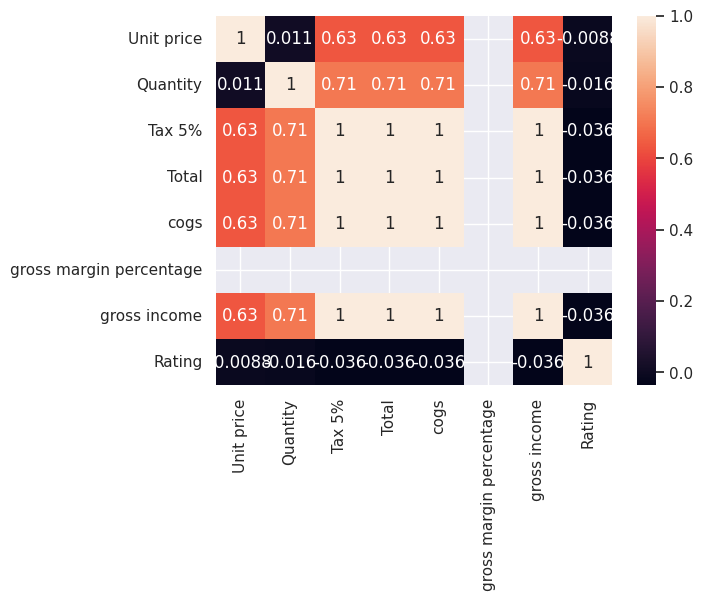

In [10]:
import seaborn as sns
sns.set()

# Heatmap
sns.heatmap(df.corr(), annot = True)

### Dropping of redundant features

In [11]:
df = df.drop(['gross margin percentage'], axis=1) #Since it does not show any variation among the rows

In [12]:
df = df.drop(['Tax 5%', 'cogs'], axis=1) #Since it shows the same correlation

In [13]:
df = df.drop(['gross income'], axis=1) #Total = quantity * unit price + gross income

In [14]:
branch_counts = df['Branch'].value_counts()

print("\nBranch Counts:")
print(branch_counts)


Branch Counts:
A    340
B    332
C    328
Name: Branch, dtype: int64


In [15]:
city_counts = df['City'].value_counts()

print("\nCity Counts:")
print(city_counts)


City Counts:
Yangon       340
Mandalay     332
Naypyitaw    328
Name: City, dtype: int64


In [16]:
# Iterate through unique values in the 'Branch' column
for branch in df['Branch'].unique():
    # Get the corresponding unique value in the 'City' column
    city = df[df['Branch'] == branch]['City'].unique()

    if len(city) == 1:
        print(f"Branch type {branch} - City type {city[0]}")
    else:
        print(f"Branch type {branch} is associated with multiple cities.")

Branch type A - City type Yangon
Branch type C - City type Naypyitaw
Branch type B - City type Mandalay


In [17]:
df = df.drop('Branch', axis=1)

### Finding the sales based on the time (morning, afternoon and night)

In [18]:
# Extract the hour from the 'PurchaseTime' column
df['PurchaseHour'] = df['DateTime'].dt.hour

# Define the boundaries for time intervals
time_intervals = [0, 6, 12, 18, 24]

# Define labels for time intervals
time_labels = ['Night', 'Morning', 'Afternoon', 'Night']

# Use pd.cut() to discretize the 'PurchaseHour' column into time intervals
df['PurchaseTimeLabel'] = pd.cut(df['PurchaseHour'], bins=time_intervals, labels=time_labels, right=False, include_lowest=True, ordered=False)

# Drop the intermediate 'PurchaseHour' column if not needed
df.drop(columns=['PurchaseHour'], inplace=True)

In [19]:
branch_counts = df['PurchaseTimeLabel'].value_counts()

print("\nPurchase Timewise Counts:")
print(branch_counts)


Purchase Timewise Counts:
Afternoon    528
Night        281
Morning      191
Name: PurchaseTimeLabel, dtype: int64


In [20]:
total_sales_by_time_label = df.groupby('PurchaseTimeLabel')['Total'].sum().reset_index()

total_sales_by_time_label

,PurchaseTimeLabel,Total
0,Afternoon,172468.5585
1,Morning,61798.8105
2,Night,88699.3800


### Plotting variation of daily sales (1/1/2019 - 30/3/2019)

In [21]:
sales_per_date = df.groupby('Date').agg({'Time': 'count', 'Total': 'sum'}).reset_index()

# Rename the columns
sales_per_date.rename(columns={'Time': 'Number of Sales', 'Total': 'Total Sales'}, inplace=True)

# Extract the day of the week (0 = Monday, 6 = Sunday)
sales_per_date['Day of Week'] = sales_per_date['Date'].dt.dayofweek
sales_per_date

,Date,Number of Sales,Total Sales,Day of Week
0,2019-01-01,12,4745.1810,1
1,2019-01-02,8,1945.5030,2
2,2019-01-03,8,2078.1285,3
3,2019-01-04,6,1623.6885,4
4,2019-01-05,12,3536.6835,5
...,...,...,...,...
84,2019-03-26,13,1962.5130,1
85,2019-03-27,10,2902.8195,2
86,2019-03-28,10,2229.4020,3
87,2019-03-29,8,4023.2430,4


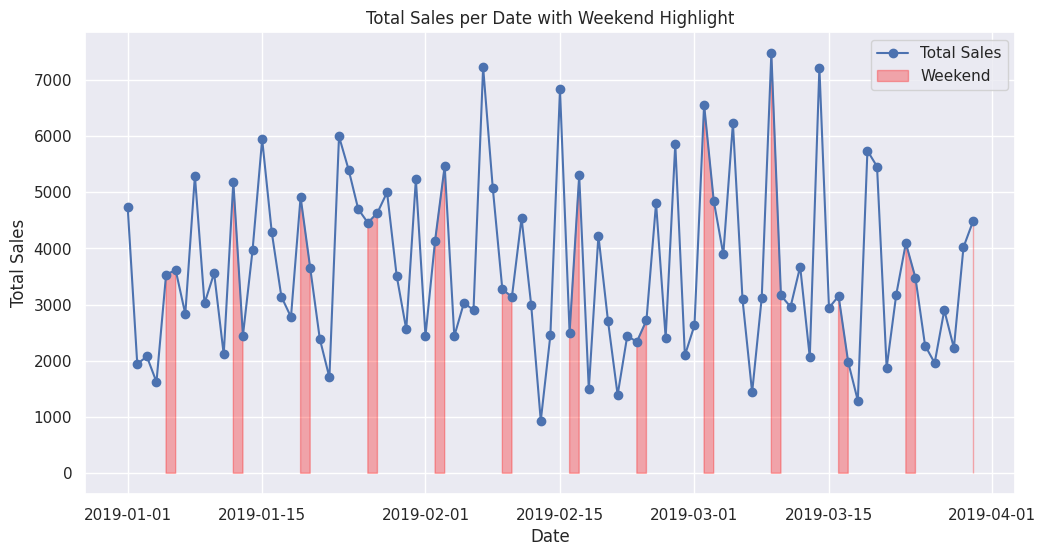

In [22]:
# Create a mask for weekends
weekend_mask = ((sales_per_date['Day of Week'] == 5) | (sales_per_date['Day of Week'] == 6))

# Plot the total sales
plt.figure(figsize=(12, 6))
plt.plot(sales_per_date['Date'], sales_per_date['Total Sales'], marker='o', linestyle='-', label='Total Sales')

# Highlight weekends (Saturday and Sunday) with a different color
plt.fill_between(sales_per_date['Date'], 0, sales_per_date['Total Sales'], where=weekend_mask, alpha=0.3, color='red', label='Weekend')

plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Total Sales per Date with Weekend Highlight')
plt.grid(True)
plt.legend()
plt.show()

In [23]:
df = df.drop(['Date','Time'], axis=1)

### Finding sales based on cities for different time ranges

In [24]:
total_sales_by_City = df.groupby('City').agg({'DateTime': 'count', 'Total': 'sum'}).reset_index()

total_sales_by_City.rename(columns={'DateTime': 'Number of Sales', 'Total': 'Total Sales'}, inplace=True)

total_sales_by_City

,City,Number of Sales,Total Sales
0,Mandalay,332,106197.6720
1,Naypyitaw,328,110568.7065
2,Yangon,340,106200.3705


In [25]:
# Group the data by 'PurchaseTimeLabel' and 'City', and count the number of rows in each group
sales_count = df.groupby(['PurchaseTimeLabel', 'City']).agg({'DateTime': 'count', 'Total': 'sum'}).reset_index()

sales_count.rename(columns={'DateTime': 'Number of Sales', 'Total': 'Total Sales'}, inplace=True)

# Display the result
sales_count

,PurchaseTimeLabel,City,Number of Sales,Total Sales
0,Afternoon,Mandalay,162,53648.1645
1,Afternoon,Naypyitaw,181,58851.9855
2,Afternoon,Yangon,185,59968.4085
3,Morning,Mandalay,59,19347.6570
4,Morning,Naypyitaw,59,19892.8485
5,Morning,Yangon,73,22558.3050
6,Night,Mandalay,111,33201.8505
7,Night,Naypyitaw,88,31823.8725
8,Night,Yangon,82,23673.6570


In [26]:
# Get a copy of Customer type column
df['CustomerType'] = df['Customer type']

In [27]:
# Create a `LabelEncoder` object
encoder = LabelEncoder()

# Encode CustomerType column

# Fit the encoder to the `Unit Price Binned` column
encoder.fit(df['CustomerType'])

# Transform the `Unit Price Binned` column to numerical values
df['CustomerType'] = encoder.transform(df['CustomerType'])

In [28]:
df['CustomerType'].unique()

array([0, 1])

### One-hot encoding for nominal data

In [29]:
unique_customer_type = df['Customer type'].unique()
customer_type_counts = df['Customer type'].value_counts()

print("\n Customer type Counts:")
print(customer_type_counts)


 Customer type Counts:
Member    501
Normal    499
Name: Customer type, dtype: int64


In [30]:
unique_product_line = df['Product line'].unique()
product_line_counts = df['Product line'].value_counts()

print("\nProduct line Counts:")
print(product_line_counts)


Product line Counts:
Fashion accessories       178
Food and beverages        174
Electronic accessories    170
Sports and travel         166
Home and lifestyle        160
Health and beauty         152
Name: Product line, dtype: int64


In [31]:
unique_payment = df['Payment'].unique()
payment_counts = df['Payment'].value_counts()

print("\n Payment Counts:")
print(payment_counts)


 Payment Counts:
Ewallet        345
Cash           344
Credit card    311
Name: Payment, dtype: int64


In [32]:
# apply one-hot encoding to the categorical columns
df = pd.get_dummies(df)

In [33]:
# Rename the columns with shortened names
# Replace the original column name with the shortened name
df.rename(columns={'Product line_Fashion accessories': 'Product line_Fashion', 'Product line_Food and beverages': 'Product line_Food', 'Product line_Electronic accessories': 'Product line_Electronic', 'Product line_Sports and travel': 'Product line_Sports & travel', 'Product line_Home and lifestyle': 'Product line_Home & lifestyle', 'Product line_Health and beauty': 'Product line_Health & beauty'}, inplace=True)

In [34]:
df.head()

,Unit price,Quantity,Total,Rating,DateTime,CustomerType,City_Mandalay,City_Naypyitaw,City_Yangon,Customer type_Member,...,Product line_Food,Product line_Health & beauty,Product line_Home & lifestyle,Product line_Sports & travel,Payment_Cash,Payment_Credit card,Payment_Ewallet,PurchaseTimeLabel_Afternoon,PurchaseTimeLabel_Morning,PurchaseTimeLabel_Night
Invoice ID,,,,,,,,,,,,,,,,,,,,,
750-67-8428,74.69,7,548.9715,9.1,2019-01-05 13:08:00,0,0,0,1,1,...,0,1,0,0,0,0,1,1,0,0
226-31-3081,15.28,5,80.2200,9.6,2019-03-08 10:29:00,1,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
631-41-3108,46.33,7,340.5255,7.4,2019-03-03 13:23:00,1,0,0,1,0,...,0,0,1,0,0,1,0,1,0,0
123-19-1176,58.22,8,489.0480,8.4,2019-01-27 20:33:00,0,0,0,1,1,...,0,1,0,0,0,0,1,0,0,1
373-73-7910,86.31,7,634.3785,5.3,2019-02-08 10:37:00,1,0,0,1,0,...,0,0,0,1,0,0,1,0,1,0


### Discretization and integer coding for unit price

In [35]:
unique_unit_price = df['Unit price'].unique()
unit_price_counts = df['Unit price'].value_counts()

print("\n Unit price Counts:")
unit_price_counts


 Unit price Counts:


83.77    3
39.62    2
24.74    2
19.15    2
73.47    2
        ..
57.95    1
47.65    1
42.82    1
48.09    1
88.34    1
Name: Unit price, Length: 943, dtype: int64

In [36]:
# Define the number of bins and their boundaries
num_bins = 9
bin_boundaries = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]  # Define your bin boundaries as needed

# Define bin labels
bin_labels = [f"{bin_boundaries[i]}-{bin_boundaries[i+1]}" for i in range(len(bin_boundaries)-1)]

# Perform equal width binning and assign labels
df['Unit Price Binned'] = pd.cut(df['Unit price'], bins=bin_boundaries, labels=bin_labels)

In [37]:
# Define the number of bins and their boundaries
num_bins = 9
bin_boundaries = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]  # Define your bin boundaries as needed

# Perform equal width binning
df['Unit Price_coded'] = pd.cut(df['Unit price'], bins=bin_boundaries, labels=False)

In [38]:
unique_unit_price_coded = df['Unit Price_coded'].unique()
unit_price_coded_counts = df['Unit Price_coded'].value_counts()

print("\n Unit price Counts:")
unit_price_coded_counts


 Unit price Counts:


8    127
6    120
1    118
4    108
2    108
3    107
0    106
7    105
5    101
Name: Unit Price_coded, dtype: int64

In [39]:
df = df.drop(['Unit price'], axis=1) #Since we discritize it

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 750-67-8428 to 849-09-3807
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Quantity                       1000 non-null   int64         
 1   Total                          1000 non-null   float64       
 2   Rating                         1000 non-null   float64       
 3   DateTime                       1000 non-null   datetime64[ns]
 4   CustomerType                   1000 non-null   int64         
 5   City_Mandalay                  1000 non-null   uint8         
 6   City_Naypyitaw                 1000 non-null   uint8         
 7   City_Yangon                    1000 non-null   uint8         
 8   Customer type_Member           1000 non-null   uint8         
 9   Customer type_Normal           1000 non-null   uint8         
 10  Gender_Female                  1000 non-null   uint8         
 11  Gende

### Min-Max Normalization

In [41]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the selected column
df['Quantity'] = scaler.fit_transform(df[['Quantity']])
df['Unit Price_coded'] = scaler.fit_transform(df[['Unit Price_coded']])

# Customer Segmentation

## Segmentation 1

In [42]:
# create a new DataFrame with only the relevant columns
df_clustering1 = df[['Customer type_Member', 'Customer type_Normal', 'Gender_Female', 'Gender_Male', 'Total']]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

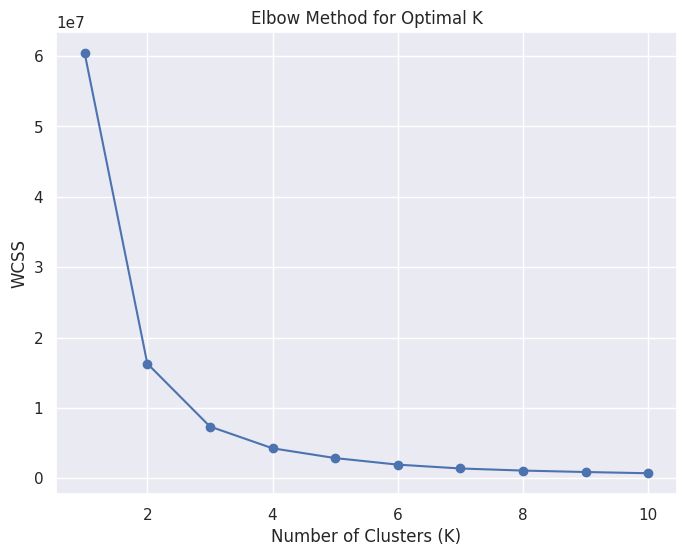

In [43]:
# Create an empty list to store the WCSS values
wcss = []

# Define a range of K values to test
k_values = range(1, 11)  # You can adjust the range as needed

# Calculate WCSS for each K value
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_clustering1)
    wcss.append(kmeans.inertia_)

# Plot the WCSS values
plt.figure(figsize=(8, 6))
plt.plot(k_values, wcss, marker='o', linestyle='-')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [44]:
# initialize the K-Means model with 3 clusters
kmeans = KMeans(n_clusters=3)

# fit the model to the data
kmeans.fit(df_clustering1)

# predict the clusters for each data point
predicted_clusters = kmeans.predict(df_clustering1)

# add the predicted clusters as a new column to the DataFrame
df_clustering1['Segment'] = predicted_clusters

# group the data by segment and calculate the average total amount spent by each segment
df_segment_sales = df_clustering1.groupby('Segment')['Total'].mean()
print(df_segment_sales)

Segment
0    132.628777
1    759.660586
2    403.044149
Name: Total, dtype: float64


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-44-a522ac898365>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clustering1['Segment'] = predicted_clusters


In [45]:
# group the data by segment and customer type

df_segment_type = df_clustering1.groupby(['Segment', 'Customer type_Member', 'Customer type_Normal']).size()
print(df_segment_type)

Segment  Customer type_Member  Customer type_Normal
0        0                     1                       267
         1                     0                       252
1        0                     1                        82
         1                     0                        87
2        0                     1                       150
         1                     0                       162
dtype: int64


In [46]:
# group the data by segment and customer type

df_segment_type = df_clustering1.groupby(['Segment', 'Customer type_Member', 'Customer type_Normal','Gender_Female', 'Gender_Male']).size()
print(df_segment_type)

Segment  Customer type_Member  Customer type_Normal  Gender_Female  Gender_Male
0        0                     1                     0              1              152
                                                     1              0              115
         1                     0                     0              1              120
                                                     1              0              132
1        0                     1                     0              1               44
                                                     1              0               38
         1                     0                     0              1               39
                                                     1              0               48
2        0                     1                     0              1               63
                                                     1              0               87
         1                     0                  

## Segmentation 2

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 750-67-8428 to 849-09-3807
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Quantity                       1000 non-null   float64       
 1   Total                          1000 non-null   float64       
 2   Rating                         1000 non-null   float64       
 3   DateTime                       1000 non-null   datetime64[ns]
 4   CustomerType                   1000 non-null   int64         
 5   City_Mandalay                  1000 non-null   uint8         
 6   City_Naypyitaw                 1000 non-null   uint8         
 7   City_Yangon                    1000 non-null   uint8         
 8   Customer type_Member           1000 non-null   uint8         
 9   Customer type_Normal           1000 non-null   uint8         
 10  Gender_Female                  1000 non-null   uint8         
 11  Gende

In [48]:
# create a new DataFrame with only the relevant columns
df_clustering2 = df[['City_Mandalay', 'City_Naypyitaw', 'City_Yangon', 'Product line_Electronic', 'Product line_Fashion', 'Product line_Food', 'Product line_Health & beauty', 'Product line_Home & lifestyle', 'Product line_Sports & travel', 'Total']]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

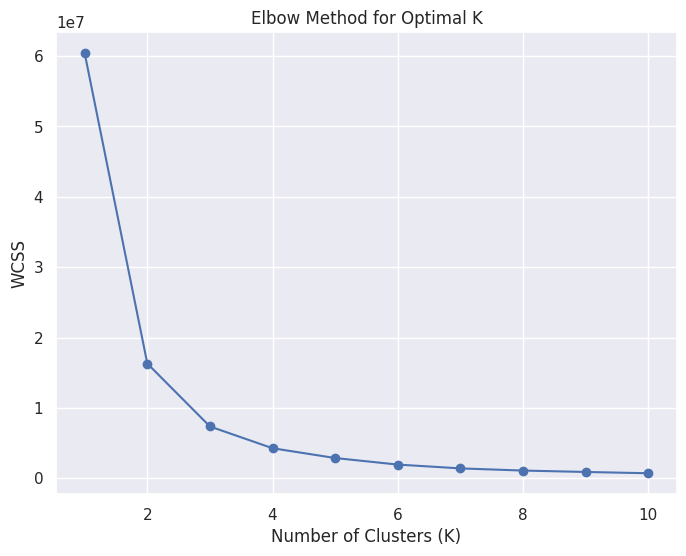

In [49]:
# Create an empty list to store the WCSS values
wcss = []

# Define a range of K values to test
k_values = range(1, 11)  # You can adjust the range as needed

# Calculate WCSS for each K value
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_clustering2)
    wcss.append(kmeans.inertia_)

# Plot the WCSS values
plt.figure(figsize=(8, 6))
plt.plot(k_values, wcss, marker='o', linestyle='-')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [50]:
# initialize the K-Means model with 3 clusters
kmeans = KMeans(n_clusters=3)

# fit the model to the data
kmeans.fit(df_clustering2)

# predict the clusters for each data point
predicted_clusters = kmeans.predict(df_clustering2)

# add the predicted clusters as a new column to the DataFrame
df_clustering2['Segment'] = predicted_clusters

# group the data by segment and calculate the average total amount spent by each segment
df_segment_sales = df_clustering2.groupby('Segment')['Total'].mean()
print(df_segment_sales)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Segment
0    132.628777
1    403.044149
2    759.660586
Name: Total, dtype: float64


<ipython-input-50-cb8d80e2370c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clustering2['Segment'] = predicted_clusters


In [51]:
# group the data by segment and customer type

df_segment_type = df_clustering2.groupby(['Segment', 'City_Mandalay', 'City_Naypyitaw', 'City_Yangon']).size()
print(df_segment_type)

Segment  City_Mandalay  City_Naypyitaw  City_Yangon
0        0              0               1              182
                        1               0              162
         1              0               0              175
1        0              0               1              108
                        1               0              103
         1              0               0              101
2        0              0               1               50
                        1               0               63
         1              0               0               56
dtype: int64


In [52]:
# group the data by segment and customer type

df_segment_type = df_clustering2.groupby(['Segment', 'Product line_Electronic', 'Product line_Fashion', 'Product line_Food', 'Product line_Health & beauty', 'Product line_Home & lifestyle', 'Product line_Sports & travel']).size()
print(df_segment_type)

Segment  Product line_Electronic  Product line_Fashion  Product line_Food  Product line_Health & beauty  Product line_Home & lifestyle  Product line_Sports & travel
0        0                        0                     0                  0                             0                              1                               82
                                                                                                         1                              0                               83
                                                                           1                             0                              0                               74
                                                        1                  0                             0                              0                               90
                                  1                     0                  0                             0                              0              

# Predict Customer Ratings

## Using Regression models

In [53]:
# Create a copy of the df
df_reg = df.copy()

# Convert the 'DateTime' column to a numerical format
df_reg['DateTime'] = df_reg['DateTime'].apply(lambda x: x.timestamp())

# Round the 'Rating' column to the nearest integer
df_reg['Rating'] = df_reg['Rating'].round().astype(int)

In [54]:
X = df_reg.drop(columns=['Rating', 'Unit Price Binned'])
y = df_reg['Rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Linear Regression

In [55]:
# Create a linear regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Calculate Mean Squared Error (MSE) and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 3.4540073601512145
R-squared: -0.022084663628988865


### Linear Regression with cross validation

In [56]:
# Define cross-validation method to use
cv = KFold(n_splits=10, random_state=1, shuffle=True)

# Create the linear regression model
model = LinearRegression()

# Perform 10-fold cross validation
linear_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error')
print("Cross-validated R^2 scores:", linear_scores)

linear_predictions = cross_val_predict(model, X, y, cv=cv)
print("Mean squared error: ", np.mean(np.absolute(linear_scores)))

Cross-validated R^2 scores: [-1.66366003 -1.92122703 -1.86097514 -1.79471862 -1.80762703 -1.85549259
 -1.84958404 -1.84027175 -1.84996768 -1.74074076]
Mean squared error:  1.8184264663837557


Both cases give negative R^2 vales, which means using regression models for predicting the rating is not appropriate. This could be due the less number of quanitative variables in the dataset. Hence it is better to descritize the Rating column and apply classification models to predit the classes.

## Using Classification models

In [57]:
# Create a copy of the df
df_class = df.copy()

# Convert the 'DateTime' column to a numerical format
df_class['DateTime'] = df_class['DateTime'].apply(lambda x: x.timestamp())

# Round the 'Rating' column to the nearest integer
df_class['Rating'] = pd.cut(df_class['Rating'], bins=3, labels=[1, 2, 3])

Labels
*   1: Low
*   2: Medium
*   3: High

In [58]:
X = df_class.drop(columns=['Rating', 'Unit Price Binned'])
y = df_class['Rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

*   Precision = True Positives / (True Positives + False Positives)
*   Recall = True Positives / (True Positives + False Negatives)
*   F1-Score = 2 * (Precision * Recall) / (Precision + Recall)
*   Support: Number of actual occurrences of class in the testing dataset

### Decision Tree

In [59]:
# Create a Decision Tree classifier
dt_model = DecisionTreeClassifier()

# Fit the model to the training data
dt_model.fit(X_train, y_train)

# Predict the ratings for the test data
y_pred_dt = dt_model.predict(X_test)

# Calculate the confusion matrix
dt_cm = confusion_matrix(y_test, y_pred_dt)
print('Confusion Matrix:\n', dt_cm)
print("\n")

# Calculate precision, recall, and F1-score
dt_report = classification_report(y_test, y_pred_dt)
print('Classification Report:\n', dt_report)

Confusion Matrix:
 [[25 23 23]
 [22 24 19]
 [18 23 23]]


Classification Report:
               precision    recall  f1-score   support

           1       0.38      0.35      0.37        71
           2       0.34      0.37      0.36        65
           3       0.35      0.36      0.36        64

    accuracy                           0.36       200
   macro avg       0.36      0.36      0.36       200
weighted avg       0.36      0.36      0.36       200



### Naive Bayes

In [60]:
# Create a Gaussian Naive Bayes classifier
nb_model = MultinomialNB()

# Fit the model to the training data
nb_model.fit(X_train, y_train)

# Predict the ratings for the test data
y_pred_nb = nb_model.predict(X_test)

# Calculate the confusion matrix
nb_cm = confusion_matrix(y_test, y_pred_nb)
print('Confusion Matrix:\n', nb_cm)
print("\n")

# Calculate precision, recall, and F1-score
nb_report = classification_report(y_test, y_pred_nb)
print('Classification Report:\n', nb_report)

Confusion Matrix:
 [[28 40  3]
 [27 37  1]
 [31 32  1]]


Classification Report:
               precision    recall  f1-score   support

           1       0.33      0.39      0.36        71
           2       0.34      0.57      0.43        65
           3       0.20      0.02      0.03        64

    accuracy                           0.33       200
   macro avg       0.29      0.33      0.27       200
weighted avg       0.29      0.33      0.27       200



### Random Forest

In [61]:
# Create a Random Forest classifier
rf_model = RandomForestClassifier()

# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Predict the ratings for the test data
y_pred_rf = rf_model.predict(X_test)

# Calculate the confusion matrix
rf_cm = confusion_matrix(y_test, y_pred_rf)
print('Confusion Matrix:\n', rf_cm)
print("\n")

# Calculate precision, recall, and F1-score
rf_report = classification_report(y_test, y_pred_rf)
print('Classification Report:\n', rf_report)

Confusion Matrix:
 [[20 31 20]
 [24 21 20]
 [24 27 13]]


Classification Report:
               precision    recall  f1-score   support

           1       0.29      0.28      0.29        71
           2       0.27      0.32      0.29        65
           3       0.25      0.20      0.22        64

    accuracy                           0.27       200
   macro avg       0.27      0.27      0.27       200
weighted avg       0.27      0.27      0.27       200



## Comparison

In [62]:
eval_data = [
    ["Metric", "Decision Tree", "Naive Bayes", "Random Forest"],
    ["Accuracy",
     accuracy_score(y_test, y_pred_dt),
     accuracy_score(y_test, y_pred_nb),
     accuracy_score(y_test, y_pred_rf)],
    ["Precision",
     precision_score(y_test, y_pred_dt, average='weighted'),
     precision_score(y_test, y_pred_nb, average='weighted'),
     precision_score(y_test, y_pred_rf, average='weighted')],
    ["Recall",
     recall_score(y_test, y_pred_dt, average='weighted'),
     recall_score(y_test, y_pred_nb, average='weighted'),
     recall_score(y_test, y_pred_rf, average='weighted')],
    ["F1 Score",
     f1_score(y_test, y_pred_dt, average='weighted'),
     f1_score(y_test, y_pred_nb, average='weighted'),
     f1_score(y_test, y_pred_rf, average='weighted')]
]

rating_table = tabulate(eval_data, headers="firstrow", tablefmt="fancy_grid")
print(rating_table)

╒═══════════╤═════════════════╤═══════════════╤═════════════════╕
│ Metric    │   Decision Tree │   Naive Bayes │   Random Forest │
╞═══════════╪═════════════════╪═══════════════╪═════════════════╡
│ Accuracy  │        0.36     │      0.33     │        0.27     │
├───────────┼─────────────────┼───────────────┼─────────────────┤
│ Precision │        0.361198 │      0.289902 │        0.269295 │
├───────────┼─────────────────┼───────────────┼─────────────────┤
│ Recall    │        0.36     │      0.33     │        0.27     │
├───────────┼─────────────────┼───────────────┼─────────────────┤
│ F1 Score  │        0.360179 │      0.274118 │        0.268061 │
╘═══════════╧═════════════════╧═══════════════╧═════════════════╛


## Plotting average ratings of different product lines

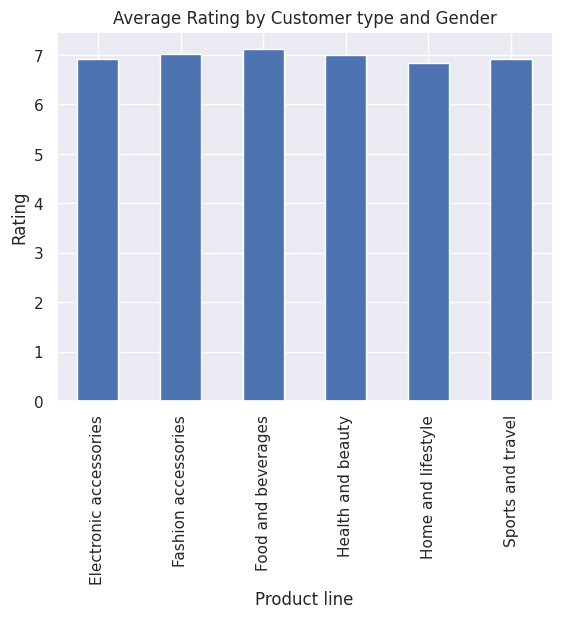

In [63]:
product_rating = data.groupby(['Product line'])['Rating'].mean()

# Plot the graph
product_rating.plot(kind='bar')
plt.xlabel('Product line')
plt.ylabel('Rating')
plt.title('Average Rating by Customer type and Gender')
plt.show()

## Plotting average ratings at each branch by each gender

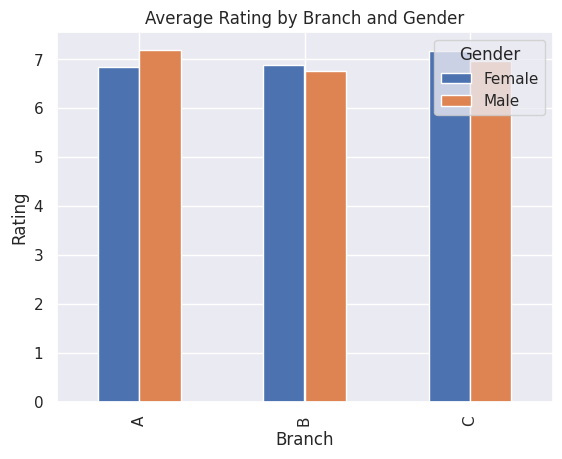

In [64]:
branch_gender_rating = data.groupby(['Branch', 'Gender'])['Rating'].mean().unstack()

# Plot the graph
branch_gender_rating.plot(kind='bar')
plt.xlabel('Branch')
plt.ylabel('Rating')
plt.title('Average Rating by Branch and Gender')
plt.legend(title='Gender', loc='upper right')
plt.show()

## Plotting average ratings at each branch by each customer type

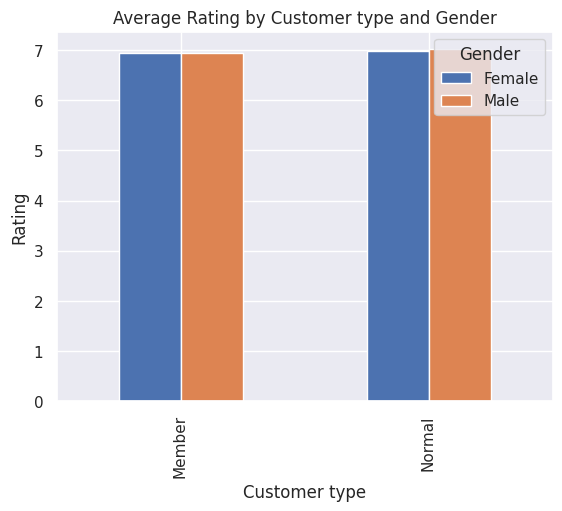

In [65]:
customer_gender_rating = data.groupby(['Customer type', 'Gender'])['Rating'].mean().unstack()

# Plot the graph
customer_gender_rating.plot(kind='bar')
plt.xlabel('Customer type')
plt.ylabel('Rating')
plt.title('Average Rating by Customer type and Gender')
plt.legend(title='Gender', loc='upper right')
plt.show()

# Predict Customer Type

In [66]:
# Encode the Unit Price Binned column

# Fit the encoder to the `Unit Price Binned` column
encoder.fit(df['Unit Price Binned'])

# Transform the `Unit Price Binned` column to numerical values
df['Unit Price Binned'] = encoder.transform(df['Unit Price Binned'])

## Using Logistic Regression Model

In [67]:
# Split the data into train and test sets
X = df[['Quantity', 'Total', 'Rating', 'City_Mandalay', 'City_Naypyitaw', 'City_Yangon',
        'Gender_Female', 'Gender_Male', 'Product line_Electronic', 'Product line_Fashion',
        'Product line_Food', 'Product line_Health & beauty', 'Product line_Home & lifestyle',
        'Product line_Sports & travel', 'Payment_Cash', 'Payment_Credit card', 'Payment_Ewallet',
        'PurchaseTimeLabel_Afternoon', 'PurchaseTimeLabel_Morning', 'PurchaseTimeLabel_Night',
        'Unit Price Binned', 'Unit Price_coded']]

y = df['CustomerType']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a logistic regression model
logistic_model = LogisticRegression()

# Train the model on the training data
logistic_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_logistic = logistic_model.predict(X_test)

# Evaluate the model
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
precision_logistic = precision_score(y_test, y_pred_logistic)
recall_logistic = recall_score(y_test, y_pred_logistic)
f1_logistic = f1_score(y_test, y_pred_logistic)

# Printing the accuracy
print("Accuracy - ", accuracy_logistic);

Accuracy -  0.525


## Using Random Forest Classifier

In [68]:
# Create a Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

# Printing the accuracy
print("Accuracy:", accuracy_rf)

Accuracy: 0.505


## Using Decision Tree

In [69]:
# Create a Decision Tree classifier
dt_model = DecisionTreeClassifier(random_state=42)

# Train the model on the training data
dt_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_dt = dt_model.predict(X_test)

# Evaluate the model's accuracy
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)

# Printing the accuracy
print("Accuracy:", accuracy_dt)

Accuracy: 0.49


## Comparing Performances

In [70]:
data = [
    ["Metric", "Logistic Regression", "Random Forest", "Decision Tree"],
    ["Accuracy", accuracy_logistic, accuracy_rf, accuracy_dt],
    ["Precision", precision_logistic, precision_rf, precision_dt],
    ["Recall", recall_logistic, recall_rf, recall_dt],
    ["F1 Score", f1_logistic, f1_rf, f1_dt]
]

table = tabulate(data, headers="firstrow", tablefmt="fancy_grid")
print(table)

╒═══════════╤═══════════════════════╤═════════════════╤═════════════════╕
│ Metric    │   Logistic Regression │   Random Forest │   Decision Tree │
╞═══════════╪═══════════════════════╪═════════════════╪═════════════════╡
│ Accuracy  │              0.525    │        0.505    │        0.49     │
├───────────┼───────────────────────┼─────────────────┼─────────────────┤
│ Precision │              0.538462 │        0.521277 │        0.504673 │
├───────────┼───────────────────────┼─────────────────┼─────────────────┤
│ Recall    │              0.543689 │        0.475728 │        0.524272 │
├───────────┼───────────────────────┼─────────────────┼─────────────────┤
│ F1 Score  │              0.541063 │        0.497462 │        0.514286 │
╘═══════════╧═══════════════════════╧═════════════════╧═════════════════╛
